<a href="https://colab.research.google.com/github/janputra/Physic-Informed-Neural-Networks-Practices-/blob/main/_PINN_Straight_horn_staticloading_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import pathlib 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import os
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from tensorflow.keras.utils import plot_model


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')



In [ ]:
tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
us=11.5e-6
ut=11.2e-6
ts=1e-4
xs=1.212e-1
## Training grid 
XMIN, XMAX = 0.0, 1
TMIN, TMAX = 0.0, 2
Xmesh = np.linspace(XMIN, XMAX, 100).reshape((-1, 1))
Tmesh = np.linspace(TMIN, TMAX, 100).reshape((-1, 1))
X, T = np.meshgrid(Xmesh, Tmesh)

input_data = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

input_data

array([[0.        , 0.        ],
       [0.01010101, 0.        ],
       [0.02020202, 0.        ],
       ...,
       [0.97979798, 2.        ],
       [0.98989899, 2.        ],
       [1.        , 2.        ]])

In [ ]:
col_p=np.linspace(TMIN, TMAX, 2000).reshape((-1,1))
idx= np.random.choice(col_p.shape[0],1000, replace=False)

t_test=col_p[idx]
zero=np.zeros(t_test.shape[0])
x_end=XMAX*np.ones(t_test.shape[0])
t_test_init=np.hstack((zero.flatten()[:,None],t_test.flatten()[:,None]))
t_test_end=np.hstack((x_end.flatten()[:,None],t_test.flatten()[:,None]))

x_t0=np.linspace(XMIN, XMAX, 2000).reshape((-1,1))
idx= np.random.choice(col_p.shape[0],1000, replace=False)
x_test= x_t0[idx]
x_test= np.append(x_test,[0,1])
zero=np.zeros(x_test.shape[0])
BC_t0_x=np.hstack((x_test.flatten()[:,None],zero.flatten()[:,None]))


u0=1
u0=np.array(u0).reshape(1,1)
u1=-ut/us
u1=np.array(u1).reshape(1,1)

x0=0
x0=np.array(x0).reshape(1,1)
x1=1
x1=np.array(x1).reshape(1,1)


In [ ]:
# omega=2*math.pi*(1/50)

# temp=-10*np.exp(omega*1j*Tmesh)
# plt.figure()
# plt.plot(Tmesh,temp.real)

In [ ]:
def build_model(layers):
    i = Input(shape=(layers[0],))
    o = Dense(layers[1],activation="tanh")(i) 
    for x in layers[2:-1]:
        o = Dense(x,activation="tanh")(o)
    o = Dense(layers[-1],activation="linear")(o)
    model=Model(inputs=i, outputs=o)
    return model

In [ ]:
layers=[2,40,40,40,40,40,1]
layers1=[1,40,40,40,40,40,1]
model=build_model(layers)
model.summary()

# alpha=build_model(layers1)
# alpha.summary()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [ ]:
  # The actual PINN
c0=5.028e3
c1=(xs**2)/((c0**2)*(ts**2))  

freq=20000
k0=(freq*math.pi*2)/c0
k1=(k0**2)*(xs**2)

c = tf.Variable([c1], dtype=tf.float32)
k = tf.Variable([k1], dtype=tf.float32)
d = tf.Variable([1], dtype=tf.float32)
def cal_t(c,k):
    return math.sqrt(c/k)*math.pi*2

def pde():
    # Using the new GradientTape paradigm of TF2.0,
    # which keeps track of operations to get the gradient at runtime
    
    x_f = tf.convert_to_tensor(input_data[:, 0:1], dtype=tf.float32)
    t_f = tf.convert_to_tensor(input_data[:, 1:2], dtype=tf.float32)
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_f)
        tape.watch(t_f)
        X_f = tf.stack([x_f[:,0], t_f[:,0]], axis=1)
        
      # Getting the prediction
        u=model(X_f)
        # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
        u_x = tape.gradient(u, x_f)
        u_t = tape.gradient(u,t_f)
        
    u_tt = tape.gradient(u_t, t_f) 
    u_xx= tape.gradient(u_x,x_f)
    
    # Letting the tape go
    del tape
    
    # Buidling the PINNs
    # return u_xx+(u_tt*(k/((omega0**2)*(math.pi**2)*4)))
    return u_xx+(d*ut)+(u_tt*c)


def bc_x0(a0):
    t_f=tf.convert_to_tensor(t_test_init[:, 1:2], dtype=tf.float32)
    t=cal_t(c,k)
    u=a0*tf.math.sin((2*math.pi/t)*t_f) 
    return u

def bc_xl(a1):
    t=cal_t(c,k)
    t_f=tf.convert_to_tensor(t_test_end[:, 1:2], dtype=tf.float32)
    u=a1*tf.math.sin((2*math.pi/t)*t_f) 
    return u


def _wrap_training_variables():
    var=model.trainable_variables
    var.extend([d])
    return var

def _loss():
    f_pde=pde()
    f_bc_x0=bc_x0(u0)
    f_bc_xl=bc_xl(u1)
    
    return tf.reduce_mean(tf.square(f_pde)) + tf.reduce_mean(tf.square(f_bc_x0-model(t_test_init))) +tf.reduce_mean(tf.square(f_bc_xl-model(t_test_end))) # +tf.reduce_mean(tf.square(f_bc_t0))+\
          # tf.square(f_bc_t0[-2]-u0) + tf.square(f_bc_t0[-1]-u0) + tf.square(u1_x[-1]) + tf.square(u1_x[-2]) 

def _grad():
    with tf.GradientTape() as tape:
          loss_value = _loss()
    return loss_value, tape.gradient(loss_value, _wrap_training_variables())

# def fit():
#     for epoch in range(epochs):
#         # Optimization step
#         loss_value, grads = _grad()
#         optimizer.apply_gradients(zip(grads, _wrap_training_variables()))
#         if epoch%10==0:
#           print ('epoch : ',epoch,' loss : ',loss_value )
#     # print ('epoch : ',epoch,' loss : ',loss_value )

def fit():
    loss_value=1
    epoch=0
    while loss_value>0.03:
        # Optimization step
        loss_value, grads = _grad()
        optimizer.apply_gradients(zip(grads, _wrap_training_variables()))
        epoch=epoch+1
        if epoch%10==0:
          print ('epoch : ',epoch,' loss : ',loss_value )

def predict(x):
    return model(x)


In [ ]:
# f_bc_t0, u1_x=bc_t0()
# f_bc_t0[-2]


In [ ]:
optimizer = tf.keras.optimizers.Adam(
  learning_rate=0.001)

In [ ]:
epochs = 40000
fit() 


Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Tanh in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAddGrad in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TanhGrad in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Unpack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSliceGrad in device /job:localhost/replica:0/task:0/device:GPU:

In [ ]:
Xmesh1 = np.linspace(XMIN, XMAX, 1000).reshape((-1, 1))
Tmesh1 = np.linspace(TMIN, TMAX, 200).reshape((-1, 1))
X1, T1 = np.meshgrid(Xmesh1, Tmesh1)

d_test=np.hstack((X1.flatten()[:,None], T1.flatten()[:,None]))
d_test.shape




(200000, 2)

In [ ]:
res=model(d_test)
res=res.numpy()
res=res.reshape(-1,Xmesh1.shape[0])

# res_a=alpha(d_test[:, 0:1])
# res_a=res_a.numpy()
# res_a=res_a.reshape(-1,Xmesh1.shape[0])

res.shape

(200, 1000)

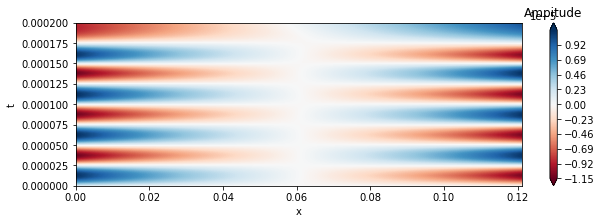

In [ ]:
plt.figure(figsize=(10,3))
plt.xlabel('x')
plt.ylabel('t')

levels=np.arange(-1*us,1*us,0.001*us)
plt.contourf(X1*xs,T1*ts,res*us,levels,cmap='RdBu',extend='both' )
#plt.contourf(X1,T1,res,cmap='RdBu',extend='both' )
clb = plt.colorbar()
clb.ax.set_title('Ampitude')
plt.show()

In [ ]:
# plt.figure(figsize=(10,3))
# plt.xlabel('x')
# plt.ylabel('t')

# # levels=np.arange(-0.1*us,0.1*us,0.001*us)
# plt.contourf(X1*xs,T1*ts,res_a,cmap='RdBu',extend='both' )
# #plt.contourf(X1,T1,res,cmap='RdBu',extend='both' )
# clb = plt.colorbar()
# clb.ax.set_title('Ampitude')
# plt.show()

1.1357332e-05 -1.14033655e-05


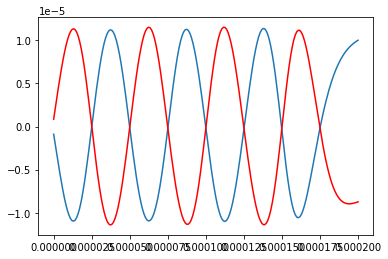

In [ ]:
plt.figure()
plt.plot(Tmesh1*ts,res[:,999]*us)
plt.plot(Tmesh1*ts,res[:,0]*us,color='r')

a=np.max(res[:,999]*us)
b=np.min(res[:,0]*us)
print(a,b)

In [ ]:
plt.figure()
plt.plot(Tmesh1*ts,res_a[:,999])
plt.plot(Tmesh1*ts,res_a[:,0],color='r')




NameError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure()
plt.plot(Tmesh1*ts,res_a[:,999]*res[:,999]*us*xs)
plt.plot(Tmesh1*ts,res[:,999]*us,color='r')




NameError: ignored

<Figure size 432x288 with 0 Axes>

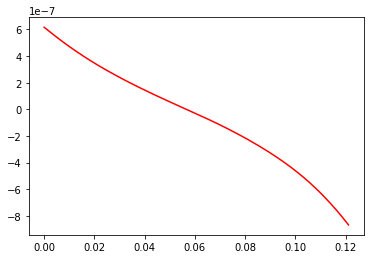

In [ ]:
plt.figure()
plt.plot(Xmesh1*xs,res[100,:]*us,color='r')

In [ ]:
plt.figure()
plt.plot(Xmesh1*xs,res_a[0,:]*xs,color='r')

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
k

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0


<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([9.175599], dtype=float32)>

In [ ]:
c

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.05810516], dtype=float32)>

In [ ]:
d

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.1137265], dtype=float32)>

In [ ]:
# name=['k','c']
# temp=np.hstack((k.numpy(),c.numpy())).reshape(-1,2)
# dummy=pd.DataFrame(temp,columns=name)
# para='para.csv'
# para_path=F"/content/gdrive/My Drive/{para}" 
# dummy.to_csv(para_path,index=False)


In [ ]:
# f_pde=pde()
# f_bc_t0, u1_x=bc_t0()
# f_bc_x0=bc_x0(f_bc_t0[-2])
# f_bc_xl=bc_xl(f_bc_t0[-1])
# print(tf.reduce_mean(tf.square(f_pde)))
# print(tf.reduce_mean(tf.square(f_bc_x0-model(t_test_init)))) 
# print(tf.reduce_mean(tf.square(f_bc_xl-model(t_test_init)))) 
# print(tf.square(f_bc_t0[-2]-u0))
# print(tf.square(f_bc_t0[-1]-u1))
# print(tf.square(u1_x[-1]))
# print(tf.square(u1_x[-2])) 

In [ ]:
# model_save_name = 'trained_model(discovery only).h5'
# path = F"/content/gdrive/My Drive/{model_save_name}" 

# model.save(path)

In [ ]:
# c=5.028e3
# ome=math.pi*2/(5e-5)
# k=ome/c
# k

In [ ]:
# k1=(k**2)*(xs**2)
# k1

In [ ]:
# c1=(xs**2)/((c**2)*(ts**2))
# c1

In [ ]:
# t=math.sqrt(c1/k1)*math.pi*2
# t

In [ ]:
# t*math.pi*2

In [ ]:
# ki=10.177227
# k=np.sqrt(ki/(xs**2))
# k

In [ ]:
# c=5.028e3
# freq=k*c/(math.pi*2)
# freq

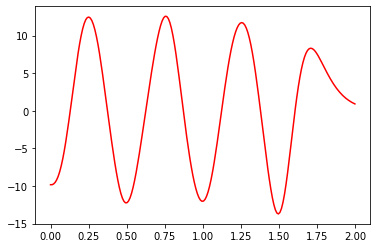

In [ ]:
E=113.8e9
area=((30e-3)**2)*math.pi
x_f = tf.convert_to_tensor(d_test[:, 0:1], dtype=tf.float32)
t_f = tf.convert_to_tensor(d_test[:, 1:2], dtype=tf.float32)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(x_f)
    tape.watch(t_f)
    X_f = tf.stack([x_f[:,0], t_f[:,0]], axis=1)
    
  # Getting the prediction
    u=model(X_f)
    # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
    u_x = tape.gradient(u, x_f)
    u_t = tape.gradient(u,t_f)
    
u_tt = tape.gradient(u_t, t_f) 
u_xx= tape.gradient(u_x,x_f)

# Letting the tape go
del tape
# a=alpha(x_f)

force= u_t
force=force.numpy()
force=force.reshape(-1,Xmesh1.shape[0])


test=np.sum(force, axis = 1)

# plt.figure(figsize=(10,3))
# plt.xlabel('x')
# plt.ylabel('t') 

# plt.contourf(X1,T1,force,cmap='RdBu',extend='both' )
# #plt.contourf(X1,T1,res,cmap='RdBu',extend='both' )
# clb = plt.colorbar()
# clb.ax.set_title('Ampitude')
plt.figure()
plt.plot(Tmesh1,force[:,999],color='r')